In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.optim.lr_scheduler import StepLR ,ReduceLROnPlateau
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader
import torchvision
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F
from tqdm import tqdm_notebook as tqdm

### Question 4 (10 marks)
Write a function train_cnn(model, train_loader) to train the following version of the Residual
Network (ResNet) model on the EXCV10 (Exeter Computer Vision 10) dataset

#### Inputs
• model is an instantiation of ResNet class which can be created as follows:
ResNet(block=BasicBlock, layers=[1, 1, 1], num_classes=num_classes). An example of
this can be found in the below snippet.
• train_loader is the training data loader. You can create the dataset and data loader for
your training following the example in the snippet below. Feel free to try other data
augmentation and regularisation techniques to train a better model.

### Outputs
• This function should not necessarily return any output, instead it should save your best
model at data/weights_resnet.pth.

In [5]:
def train_cnn(model, train_loader):

  # Training setup
    num_epochs=50
    lr=0.001
    weight_decay = 0.0005
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay,betas=(0.9, 0.999), eps=1e-08)
    scheduler = StepLR(optimizer, step_size=7, gamma=0.99)  # Learning rate scheduler
    #scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1)

    #  image transform
    image_transform =transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

    # Data loaders
    val_data = datasets.ImageFolder("drive/MyDrive/Colab Notebooks/EXCV10/val", transform=image_transform)
    val_loader = DataLoader(val_data, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)


    best_val_acc = 0.0

        # make the parameters trainable
    for param in model.parameters():
        param.requires_grad = True


    for epoch in range(1, num_epochs + 1):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

        print(f" Epoch : {epoch} ,Training Loss: {loss / len(train_loader)}")

        # Validation
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = (correct / total)*100
        print(f" Validation Accuracy: {val_acc:.2f}%")

        scheduler.step(loss / len(val_loader))


        # Save the best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), r'weights_resnet.pth')


print("Training complete!")






Training complete!


In [8]:

#transform
#  image transform
image_transform =transforms.Compose([
    transforms.RandomHorizontalFlip(),  # Randomly flip the images horizontally
    transforms.RandomRotation(10),  # Randomly rotate the images by 10 degrees
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # Normalize images
])

# Dataset
train_data = datasets.ImageFolder('drive/MyDrive/Colab Notebooks/EXCV10/train', transform=image_transform)

# Data loaders
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=6, pin_memory=True)

# ResNet model
from ca_utils import ResNet,BasicBlock
model = ResNet(BasicBlock, layers=[1,1,1], num_classes=10)

# Train the model
train_cnn(model, train_loader)

 Epoch : 1 ,Training Loss: 0.025418976321816444
 Validation Accuracy: 38.16%
 Epoch : 2 ,Training Loss: 0.023160062730312347
 Validation Accuracy: 38.66%
 Epoch : 3 ,Training Loss: 0.022208016365766525
 Validation Accuracy: 42.86%
 Epoch : 4 ,Training Loss: 0.022868944332003593
 Validation Accuracy: 50.75%
 Epoch : 5 ,Training Loss: 0.017971664667129517
 Validation Accuracy: 40.76%
 Epoch : 6 ,Training Loss: 0.016451748088002205
 Validation Accuracy: 50.55%
 Epoch : 7 ,Training Loss: 0.021881939843297005
 Validation Accuracy: 44.76%
 Epoch : 8 ,Training Loss: 0.01851898804306984
 Validation Accuracy: 55.89%
 Epoch : 9 ,Training Loss: 0.018099727109074593
 Validation Accuracy: 52.35%
 Epoch : 10 ,Training Loss: 0.013768104836344719
 Validation Accuracy: 54.90%
 Epoch : 11 ,Training Loss: 0.018743963912129402
 Validation Accuracy: 55.09%
 Epoch : 12 ,Training Loss: 0.018752826377749443
 Validation Accuracy: 57.29%
 Epoch : 13 ,Training Loss: 0.01693052239716053
 Validation Accuracy: 57.8

### Question 5 (15 marks)
Write a function test_cnn(model, test_loader) which will return the predicted labels by the
model that you trained in the previous question for all the images supplied in the test_loader
object. The test set will contain 3000 images (300 images/class) from the same distribution as
of the EXCV10 dataset.
#### Inputs
• model is an instantiation of ResNet class which can created as follows
ResNet(block=BasicBlock, layers=[1, 1, 1], num_classes=num_classes).  
• test_loader is the data loader containing test data. The test data loader can be created
following the example in the cell below. We will only use vanilla transformation to the
test dataset.
### Outputs
• This function should return a 1-dimensional numpy array of data type int64
containing the predicted labels of the images in the test_loader object.
• This function should also return the classification accuracy as a percentage

In [49]:
import torch
import numpy as np

def test_cnn(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    predicted_labels = []
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            predicted_labels.extend(predicted.cpu().numpy())
            correct_predictions += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = correct_predictions / total_samples * 100
    predicted_labels = np.array(predicted_labels, dtype=np.int64)

    return predicted_labels, accuracy


In [52]:
from PIL import Image
from torchvision import transforms, datasets

class EXCV10TestImageFolder(datasets.ImageFolder):

  def __init__(self,*args,**kwargs):
      super(EXCV10TestImageFolder,self).__init__(*args,**kwargs)

  def __getitem__(self,index):
        img_path,label =self.imgs[index]
        pic=Image.open(img_path).convert("RGB")
        if self.transform(pic) is not None:
          img=self.transform(pic)
        return img ,label

#vanilla image transform
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_data = EXCV10TestImageFolder('drive/MyDrive/Colab Notebooks/EXCV10/val', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)

# Example usage:
predicted_labels, accuracy = test_cnn(model, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")
print("Predicted Labels:", predicted_labels)

#np.save("Q5Labels.npy" , predicted_labels)
#np.save("Q5Acc.npy" , accuracy)

Test Accuracy: 72.53%
Predicted Labels: [0 0 0 ... 9 9 9]


In [57]:
q = np.load("Q5Labels.npy")
print(q)
q.dtype

[0 0 0 ... 9 9 9]


dtype('int64')

### Question 6 (6 marks)
Write compute_confusion_matrix(ture,predictions) to compute the confusion matrix for the
output labels generated in Question 5.
#### Inputs
• true is a 1-dimensional array of true labels for the test data in Question 5
• predictions is a 1-dimensional array of outputs from Question 5
Data
• You can use the output and true labels of Question 5 as your data

In [45]:
def compute_confusion_matrix(ture,predictions):
    # Identify unique classes
    classes = np.unique(np.concatenate((ture, predictions)))
    class_map = {cls: idx for idx, cls in enumerate(classes)}

    # Create the confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)))

    # Populate the confusion matrix
    for actual, pred in zip(ture, predictions):
        conf_matrix[class_map[actual], class_map[pred]] += 1

    # Normalize the confusion matrix
    conf_matrix_norm = conf_matrix / conf_matrix.sum(axis=1, keepdims=True)

    # Round to three decimal points
    conf_matrix_norm = np.round(conf_matrix_norm, 2)

    return conf_matrix_norm

In [46]:
import torch
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

Test Accuracy: 72.53%
Predicted Labels: [0 0 0 ... 9 9 9]


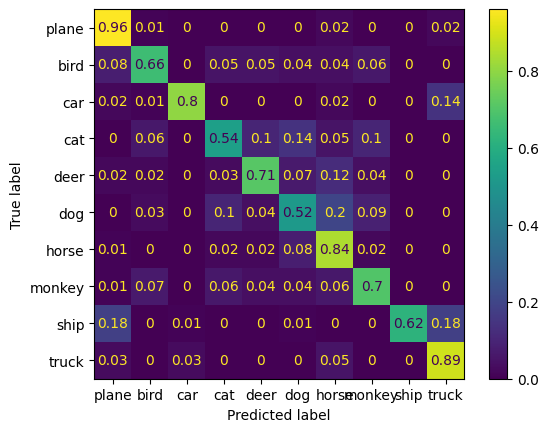

In [59]:
# Example test loader creation:
test_transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_data = EXCV10TestImageFolder('drive/MyDrive/Colab Notebooks/EXCV10/val', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=128, shuffle=False, num_workers=6, pin_memory=True)

# Example usage:
predicted_labels, accuracy = test_cnn(model, test_loader)
print(f"Test Accuracy: {accuracy:.2f}%")
print("Predicted Labels:", predicted_labels)

# Compute confusion matrix
true_labels = np.array([label for _, label in test_data.samples])
confusion_matrix_result = compute_confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_result,display_labels=['plane', 'bird', 'car','cat',
           'deer', 'dog',  'horse','monkey', 'ship', 'truck'])
disp.plot()
plt.show()

#print("Confusion Matrix:")
#print(confusion_matrix_result)

np.save("Q6.npy", confusion_matrix_result)


In [60]:
q1 = np.load("Q6.npy")
print(q1)
q1.dtype

[[0.96 0.01 0.   0.   0.   0.   0.02 0.   0.   0.02]
 [0.08 0.66 0.   0.05 0.05 0.04 0.04 0.06 0.   0.  ]
 [0.02 0.01 0.8  0.   0.   0.   0.02 0.   0.   0.14]
 [0.   0.06 0.   0.54 0.1  0.14 0.05 0.1  0.   0.  ]
 [0.02 0.02 0.   0.03 0.71 0.07 0.12 0.04 0.   0.  ]
 [0.   0.03 0.   0.1  0.04 0.52 0.2  0.09 0.   0.  ]
 [0.01 0.   0.   0.02 0.02 0.08 0.84 0.02 0.   0.  ]
 [0.01 0.07 0.   0.06 0.04 0.04 0.06 0.7  0.   0.  ]
 [0.18 0.   0.01 0.   0.   0.01 0.   0.   0.62 0.18]
 [0.03 0.   0.03 0.   0.   0.   0.05 0.   0.   0.89]]


dtype('float64')